# Transformer for Video Prediction

## Jumping Jacks

In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Paths and parameters
train_path = '/kaggle/input/ucf101-action-recognition/train/JumpingJack'
frame_size = (64, 64)
sequence_length = 10
prediction_length = 5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Preprocess video frames
def preprocess_videos(video_path, frame_size):
    data = []
    for video_file in os.listdir(video_path):
        if video_file.endswith('.avi'):  # Adjust the extension if necessary
            cap = cv2.VideoCapture(os.path.join(video_path, video_file))
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, frame_size)
                frame = frame / 255.0  # Normalize to [0, 1]
                frames.append(frame)
            cap.release()
            if len(frames) >= sequence_length + prediction_length:
                data.append(np.array(frames, dtype=np.float32))  # Ensure numeric type
    return data

video_data = preprocess_videos(train_path, frame_size)

# 2. Dataset Class
class VideoDataset(Dataset):
    def __init__(self, videos, sequence_length, prediction_length):
        self.videos = videos
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        input_frames = np.array(video[:self.sequence_length], dtype=np.float32)
        target_frames = np.array(video[self.sequence_length:self.sequence_length + self.prediction_length], dtype=np.float32)
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)

# Create dataset and dataloader
dataset = VideoDataset(video_data, sequence_length, prediction_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3. Transformer Video Predictor Model
class TransformerVideoPredictor(nn.Module):
    def __init__(self, input_dim, seq_length, embed_dim, num_heads, num_layers):
        super(TransformerVideoPredictor, self).__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(seq_length, embed_dim))
        self.transformer = nn.Transformer(
            d_model=embed_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            batch_first=True  # Fix for batch-first input
        )
        self.fc = nn.Linear(embed_dim, input_dim)

    def forward(self, x, target):
        b, t, h, w, c = x.size()
        x = x.view(b, t, -1)  # Flatten spatial dimensions
        target = target.view(b, target.size(1), -1)

        # Add positional encoding
        x_embed = self.embed(x) + self.positional_encoding
        target_embed = self.embed(target) + self.positional_encoding[:target.size(1)]

        # Transformer forward pass
        output = self.transformer(x_embed, target_embed)
        output = self.fc(output)
        return output.view(b, target.size(1), h, w, c)

# Instantiate model
input_dim = frame_size[0] * frame_size[1] * 3  # Assuming RGB frames
embed_dim = 128
num_heads = 4
num_layers = 2
model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)

# 4. Training Setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# Training loop
epochs = 60
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # Model prediction
        predictions = model(inputs, targets[:, :-1])  # Use inputs and part of targets for prediction
        
        # Align target shape with predictions
        aligned_targets = targets[:, 1:]  # Shifted by one step to match prediction sequence
        
        # Calculate loss
        loss = criterion(predictions, aligned_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1/60, Loss: 0.2043
Epoch 2/60, Loss: 0.0834
Epoch 3/60, Loss: 0.0801
Epoch 4/60, Loss: 0.0770
Epoch 5/60, Loss: 0.0768
Epoch 6/60, Loss: 0.0739
Epoch 7/60, Loss: 0.0762
Epoch 8/60, Loss: 0.0742
Epoch 9/60, Loss: 0.0719
Epoch 10/60, Loss: 0.0721
Epoch 11/60, Loss: 0.0706
Epoch 12/60, Loss: 0.0722
Epoch 13/60, Loss: 0.0718
Epoch 14/60, Loss: 0.0733
Epoch 15/60, Loss: 0.0679
Epoch 16/60, Loss: 0.0627
Epoch 17/60, Loss: 0.0598
Epoch 18/60, Loss: 0.0605
Epoch 19/60, Loss: 0.0615
Epoch 20/60, Loss: 0.0559
Epoch 21/60, Loss: 0.0509
Epoch 22/60, Loss: 0.0472
Epoch 23/60, Loss: 0.0437
Epoch 24/60, Loss: 0.0396
Epoch 25/60, Loss: 0.0384
Epoch 26/60, Loss: 0.0430
Epoch 27/60, Loss: 0.0407
Epoch 28/60, Loss: 0.0344
Epoch 29/60, Loss: 0.0332
Epoch 30/60, Loss: 0.0314
Epoch 31/60, Loss: 0.0289
Epoch 32/60, Loss: 0.0283
Epoch 33/60, Loss: 0.0283
Epoch 34/60, Loss: 0.0281
Epoch 35/60, Loss: 0.0275
Epoch 36/60, Loss: 0.0267
Epoch 37/60, Loss: 0.0267
Epoch 38/60, Loss: 0.0255
Epoch 39/60, Loss: 0.

In [2]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, test_dataset, num_frames=5):
    model.eval()
    # Select a sample from the test dataset
    inputs, targets = test_dataset[0]  # Replace with any index as needed
    inputs, targets = inputs.unsqueeze(0).to(device), targets.unsqueeze(0).to(device)  # Add batch dimension
    
    # Get predictions
    with torch.no_grad():
        predictions = model(inputs, targets[:, :-1])
    
    # Move tensors to CPU for visualization
    inputs = inputs.cpu().numpy()[0]  # Remove batch dimension
    targets = targets.cpu().numpy()[0]
    predictions = predictions.cpu().numpy()[0]

    # Plot input, ground truth, and predicted frames
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# # Visualize predictions
# visualize_predictions(model, test_dataset)

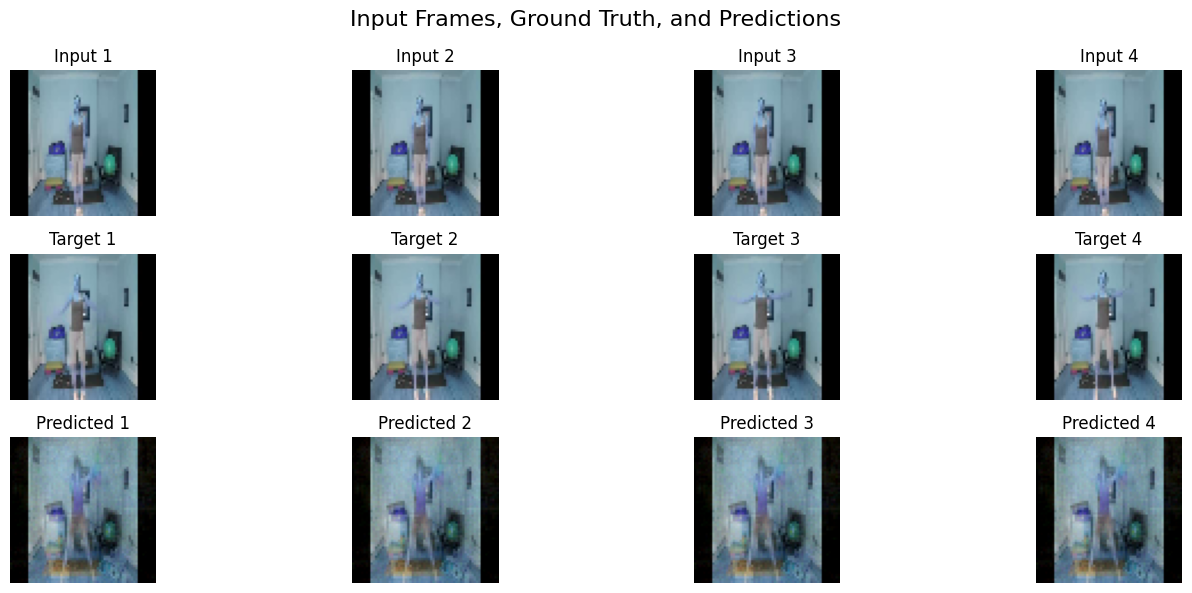

In [3]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Path to the test video
test_video_path = '/kaggle/input/ucf101-action-recognition/test/JumpingJack/v_JumpingJack_g01_c03.avi'

# Function to preprocess a single video
def preprocess_video(video_path, frame_size, sequence_length, prediction_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)  # Resize frame
        frame = frame / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()

    frames = np.array(frames, dtype=np.float32)  # Convert list of frames to numpy array
    
    # Ensure the video has enough frames
    if len(frames) >= sequence_length + prediction_length:
        input_frames = frames[:sequence_length]
        target_frames = frames[sequence_length:sequence_length + prediction_length]
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)
    else:
        raise ValueError("Not enough frames in the video for testing.")

# Preprocess the test video
test_inputs, test_targets = preprocess_video(test_video_path, frame_size, sequence_length, prediction_length)
test_inputs, test_targets = test_inputs.unsqueeze(0).to(device), test_targets.unsqueeze(0).to(device)  # Add batch dimension

# Generate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(test_inputs, test_targets[:, :-1])  # Predict frames

# Convert tensors to numpy for visualization
test_inputs = test_inputs.cpu().numpy()[0]
test_targets = test_targets.cpu().numpy()[0]
test_predictions = test_predictions.cpu().numpy()[0]

# Visualization function
def visualize_test_results(inputs, targets, predictions):
    num_frames = min(len(inputs), len(targets), len(predictions))  # Adjust frame count dynamically
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# Visualize test video results
visualize_test_results(test_inputs, test_targets, test_predictions)

In [4]:
# Save the model
model_path = '/kaggle/working/transformer_video_predictor_jumping_jack.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# # Load the model
# model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)
# model.load_state_dict(torch.load(model_path))
# model.eval()  # Set the model to evaluation mode
# print(f'Model loaded from {model_path}')

Model saved to /kaggle/working/transformer_video_predictor_jumping_jack.pth


## Walking with Dog

In [5]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Paths and parameters
train_path = '/kaggle/input/ucf101-action-recognition/train/WalkingWithDog'
frame_size = (64, 64)
sequence_length = 10
prediction_length = 5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Preprocess video frames
def preprocess_videos(video_path, frame_size):
    data = []
    for video_file in os.listdir(video_path):
        if video_file.endswith('.avi'):  # Adjust the extension if necessary
            cap = cv2.VideoCapture(os.path.join(video_path, video_file))
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, frame_size)
                frame = frame / 255.0  # Normalize to [0, 1]
                frames.append(frame)
            cap.release()
            if len(frames) >= sequence_length + prediction_length:
                data.append(np.array(frames, dtype=np.float32))  # Ensure numeric type
    return data

video_data = preprocess_videos(train_path, frame_size)

# 2. Dataset Class
class VideoDataset(Dataset):
    def __init__(self, videos, sequence_length, prediction_length):
        self.videos = videos
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        input_frames = np.array(video[:self.sequence_length], dtype=np.float32)
        target_frames = np.array(video[self.sequence_length:self.sequence_length + self.prediction_length], dtype=np.float32)
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)

# Create dataset and dataloader
dataset = VideoDataset(video_data, sequence_length, prediction_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3. Transformer Video Predictor Model
class TransformerVideoPredictor(nn.Module):
    def __init__(self, input_dim, seq_length, embed_dim, num_heads, num_layers):
        super(TransformerVideoPredictor, self).__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(seq_length, embed_dim))
        self.transformer = nn.Transformer(
            d_model=embed_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            batch_first=True  # Fix for batch-first input
        )
        self.fc = nn.Linear(embed_dim, input_dim)

    def forward(self, x, target):
        b, t, h, w, c = x.size()
        x = x.view(b, t, -1)  # Flatten spatial dimensions
        target = target.view(b, target.size(1), -1)

        # Add positional encoding
        x_embed = self.embed(x) + self.positional_encoding
        target_embed = self.embed(target) + self.positional_encoding[:target.size(1)]

        # Transformer forward pass
        output = self.transformer(x_embed, target_embed)
        output = self.fc(output)
        return output.view(b, target.size(1), h, w, c)

# Instantiate model
input_dim = frame_size[0] * frame_size[1] * 3  # Assuming RGB frames
embed_dim = 128
num_heads = 4
num_layers = 2
model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)

# 4. Training Setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# Training loop
epochs = 60
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # Model prediction
        predictions = model(inputs, targets[:, :-1])  # Use inputs and part of targets for prediction
        
        # Align target shape with predictions
        aligned_targets = targets[:, 1:]  # Shifted by one step to match prediction sequence
        
        # Calculate loss
        loss = criterion(predictions, aligned_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1/60, Loss: 0.2018
Epoch 2/60, Loss: 0.0813
Epoch 3/60, Loss: 0.0775
Epoch 4/60, Loss: 0.0748
Epoch 5/60, Loss: 0.0721
Epoch 6/60, Loss: 0.0721
Epoch 7/60, Loss: 0.0706
Epoch 8/60, Loss: 0.0711
Epoch 9/60, Loss: 0.0708
Epoch 10/60, Loss: 0.0699
Epoch 11/60, Loss: 0.0693
Epoch 12/60, Loss: 0.0682
Epoch 13/60, Loss: 0.0690
Epoch 14/60, Loss: 0.0648
Epoch 15/60, Loss: 0.0596
Epoch 16/60, Loss: 0.0599
Epoch 17/60, Loss: 0.0577
Epoch 18/60, Loss: 0.0561
Epoch 19/60, Loss: 0.0561
Epoch 20/60, Loss: 0.0557
Epoch 21/60, Loss: 0.0567
Epoch 22/60, Loss: 0.0556
Epoch 23/60, Loss: 0.0563
Epoch 24/60, Loss: 0.0548
Epoch 25/60, Loss: 0.0508
Epoch 26/60, Loss: 0.0490
Epoch 27/60, Loss: 0.0476
Epoch 28/60, Loss: 0.0468
Epoch 29/60, Loss: 0.0468
Epoch 30/60, Loss: 0.0455
Epoch 31/60, Loss: 0.0443
Epoch 32/60, Loss: 0.0425
Epoch 33/60, Loss: 0.0397
Epoch 34/60, Loss: 0.0388
Epoch 35/60, Loss: 0.0389
Epoch 36/60, Loss: 0.0384
Epoch 37/60, Loss: 0.0370
Epoch 38/60, Loss: 0.0369
Epoch 39/60, Loss: 0.

In [6]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, test_dataset, num_frames=5):
    model.eval()
    # Select a sample from the test dataset
    inputs, targets = test_dataset[0]  # Replace with any index as needed
    inputs, targets = inputs.unsqueeze(0).to(device), targets.unsqueeze(0).to(device)  # Add batch dimension
    
    # Get predictions
    with torch.no_grad():
        predictions = model(inputs, targets[:, :-1])
    
    # Move tensors to CPU for visualization
    inputs = inputs.cpu().numpy()[0]  # Remove batch dimension
    targets = targets.cpu().numpy()[0]
    predictions = predictions.cpu().numpy()[0]

    # Plot input, ground truth, and predicted frames
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# # Visualize predictions
# visualize_predictions(model, test_dataset)

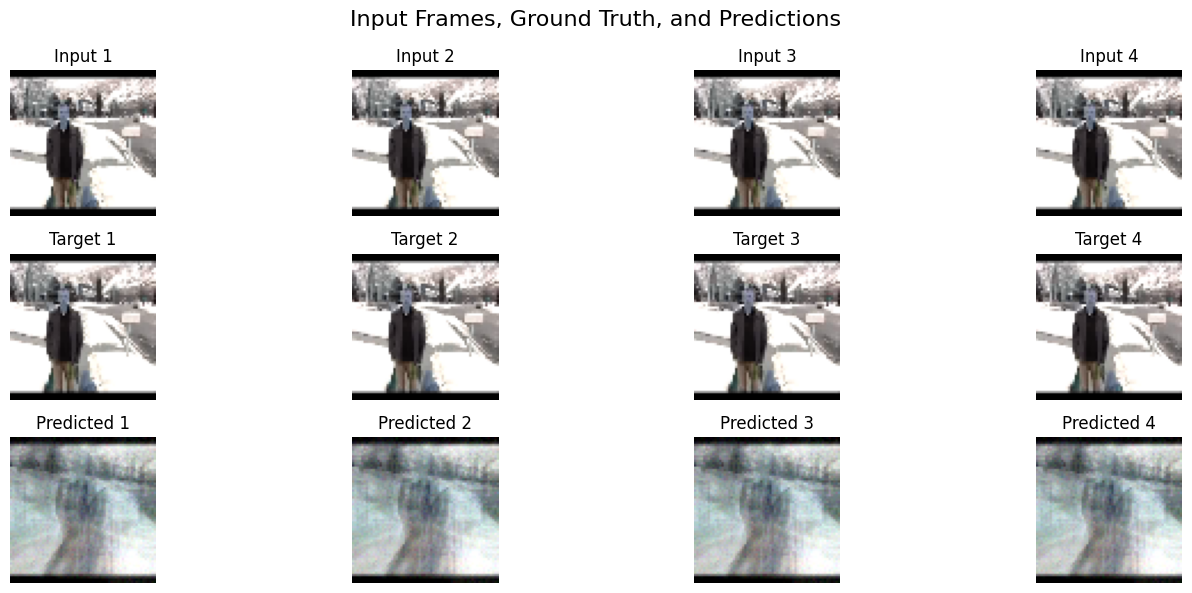

In [7]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Path to the test video
test_video_path = '/kaggle/input/ucf101-action-recognition/test/WalkingWithDog/v_WalkingWithDog_g02_c01.avi'

# Function to preprocess a single video
def preprocess_video(video_path, frame_size, sequence_length, prediction_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)  # Resize frame
        frame = frame / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()

    frames = np.array(frames, dtype=np.float32)  # Convert list of frames to numpy array
    
    # Ensure the video has enough frames
    if len(frames) >= sequence_length + prediction_length:
        input_frames = frames[:sequence_length]
        target_frames = frames[sequence_length:sequence_length + prediction_length]
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)
    else:
        raise ValueError("Not enough frames in the video for testing.")

# Preprocess the test video
test_inputs, test_targets = preprocess_video(test_video_path, frame_size, sequence_length, prediction_length)
test_inputs, test_targets = test_inputs.unsqueeze(0).to(device), test_targets.unsqueeze(0).to(device)  # Add batch dimension

# Generate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(test_inputs, test_targets[:, :-1])  # Predict frames

# Convert tensors to numpy for visualization
test_inputs = test_inputs.cpu().numpy()[0]
test_targets = test_targets.cpu().numpy()[0]
test_predictions = test_predictions.cpu().numpy()[0]

# Visualization function
def visualize_test_results(inputs, targets, predictions):
    num_frames = min(len(inputs), len(targets), len(predictions))  # Adjust frame count dynamically
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# Visualize test video results
visualize_test_results(test_inputs, test_targets, test_predictions)

In [8]:
# Save the model
model_path = '/kaggle/working/transformer_video_predictor_walking_with_dog.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# # Load the model
# model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)
# model.load_state_dict(torch.load(model_path))
# model.eval()  # Set the model to evaluation mode
# print(f'Model loaded from {model_path}')

Model saved to /kaggle/working/transformer_video_predictor_walking_with_dog.pth


## Push ups

In [9]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Paths and parameters
train_path = '/kaggle/input/ucf101-action-recognition/train/PushUps'
frame_size = (64, 64)
sequence_length = 10
prediction_length = 5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Preprocess video frames
def preprocess_videos(video_path, frame_size):
    data = []
    for video_file in os.listdir(video_path):
        if video_file.endswith('.avi'):  # Adjust the extension if necessary
            cap = cv2.VideoCapture(os.path.join(video_path, video_file))
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, frame_size)
                frame = frame / 255.0  # Normalize to [0, 1]
                frames.append(frame)
            cap.release()
            if len(frames) >= sequence_length + prediction_length:
                data.append(np.array(frames, dtype=np.float32))  # Ensure numeric type
    return data

video_data = preprocess_videos(train_path, frame_size)

# 2. Dataset Class
class VideoDataset(Dataset):
    def __init__(self, videos, sequence_length, prediction_length):
        self.videos = videos
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        input_frames = np.array(video[:self.sequence_length], dtype=np.float32)
        target_frames = np.array(video[self.sequence_length:self.sequence_length + self.prediction_length], dtype=np.float32)
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)

# Create dataset and dataloader
dataset = VideoDataset(video_data, sequence_length, prediction_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3. Transformer Video Predictor Model
class TransformerVideoPredictor(nn.Module):
    def __init__(self, input_dim, seq_length, embed_dim, num_heads, num_layers):
        super(TransformerVideoPredictor, self).__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(seq_length, embed_dim))
        self.transformer = nn.Transformer(
            d_model=embed_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            batch_first=True  # Fix for batch-first input
        )
        self.fc = nn.Linear(embed_dim, input_dim)

    def forward(self, x, target):
        b, t, h, w, c = x.size()
        x = x.view(b, t, -1)  # Flatten spatial dimensions
        target = target.view(b, target.size(1), -1)

        # Add positional encoding
        x_embed = self.embed(x) + self.positional_encoding
        target_embed = self.embed(target) + self.positional_encoding[:target.size(1)]

        # Transformer forward pass
        output = self.transformer(x_embed, target_embed)
        output = self.fc(output)
        return output.view(b, target.size(1), h, w, c)

# Instantiate model
input_dim = frame_size[0] * frame_size[1] * 3  # Assuming RGB frames
embed_dim = 128
num_heads = 4
num_layers = 2
model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)

# 4. Training Setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# Training loop
epochs = 60
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # Model prediction
        predictions = model(inputs, targets[:, :-1])  # Use inputs and part of targets for prediction
        
        # Align target shape with predictions
        aligned_targets = targets[:, 1:]  # Shifted by one step to match prediction sequence
        
        # Calculate loss
        loss = criterion(predictions, aligned_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1/60, Loss: 0.2328
Epoch 2/60, Loss: 0.1022
Epoch 3/60, Loss: 0.0921
Epoch 4/60, Loss: 0.0904
Epoch 5/60, Loss: 0.0907
Epoch 6/60, Loss: 0.0873
Epoch 7/60, Loss: 0.0871
Epoch 8/60, Loss: 0.0876
Epoch 9/60, Loss: 0.0839
Epoch 10/60, Loss: 0.0742
Epoch 11/60, Loss: 0.0646
Epoch 12/60, Loss: 0.0633
Epoch 13/60, Loss: 0.0591
Epoch 14/60, Loss: 0.0570
Epoch 15/60, Loss: 0.0523
Epoch 16/60, Loss: 0.0508
Epoch 17/60, Loss: 0.0491
Epoch 18/60, Loss: 0.0466
Epoch 19/60, Loss: 0.0448
Epoch 20/60, Loss: 0.0439
Epoch 21/60, Loss: 0.0444
Epoch 22/60, Loss: 0.0415
Epoch 23/60, Loss: 0.0410
Epoch 24/60, Loss: 0.0398
Epoch 25/60, Loss: 0.0378
Epoch 26/60, Loss: 0.0367
Epoch 27/60, Loss: 0.0364
Epoch 28/60, Loss: 0.0358
Epoch 29/60, Loss: 0.0352
Epoch 30/60, Loss: 0.0347
Epoch 31/60, Loss: 0.0346
Epoch 32/60, Loss: 0.0339
Epoch 33/60, Loss: 0.0324
Epoch 34/60, Loss: 0.0317
Epoch 35/60, Loss: 0.0305
Epoch 36/60, Loss: 0.0305
Epoch 37/60, Loss: 0.0303
Epoch 38/60, Loss: 0.0293
Epoch 39/60, Loss: 0.

In [10]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, test_dataset, num_frames=5):
    model.eval()
    # Select a sample from the test dataset
    inputs, targets = test_dataset[0]  # Replace with any index as needed
    inputs, targets = inputs.unsqueeze(0).to(device), targets.unsqueeze(0).to(device)  # Add batch dimension
    
    # Get predictions
    with torch.no_grad():
        predictions = model(inputs, targets[:, :-1])
    
    # Move tensors to CPU for visualization
    inputs = inputs.cpu().numpy()[0]  # Remove batch dimension
    targets = targets.cpu().numpy()[0]
    predictions = predictions.cpu().numpy()[0]

    # Plot input, ground truth, and predicted frames
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# # Visualize predictions
# visualize_predictions(model, test_dataset)

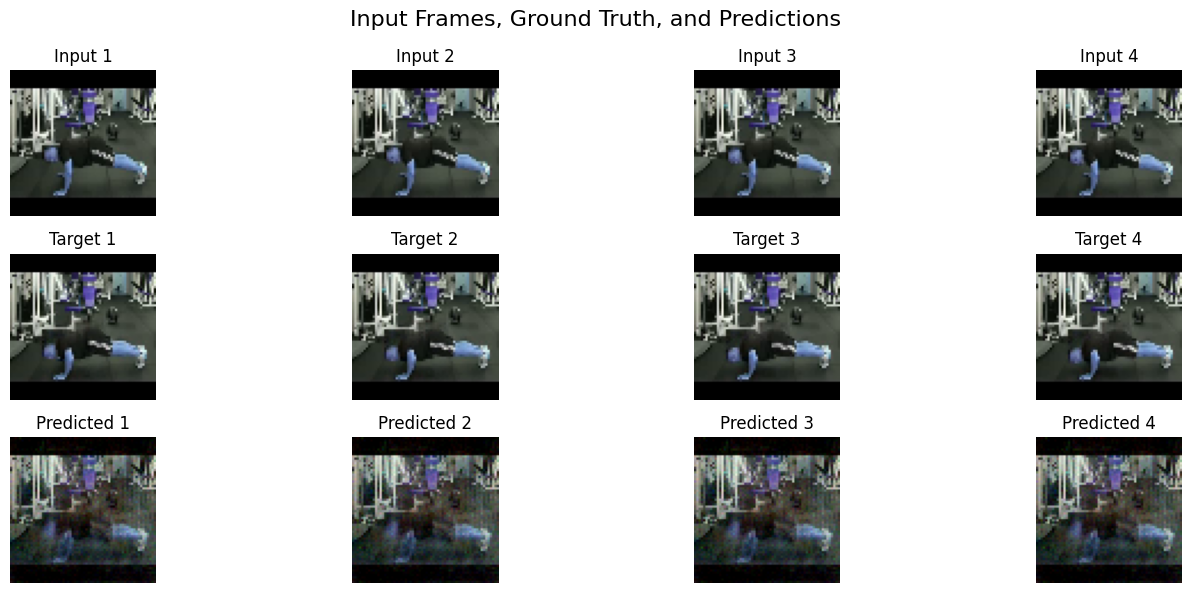

In [11]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Path to the test video
test_video_path = '/kaggle/input/ucf101-action-recognition/test/PushUps/v_PushUps_g03_c01.avi'

# Function to preprocess a single video
def preprocess_video(video_path, frame_size, sequence_length, prediction_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)  # Resize frame
        frame = frame / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()

    frames = np.array(frames, dtype=np.float32)  # Convert list of frames to numpy array
    
    # Ensure the video has enough frames
    if len(frames) >= sequence_length + prediction_length:
        input_frames = frames[:sequence_length]
        target_frames = frames[sequence_length:sequence_length + prediction_length]
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)
    else:
        raise ValueError("Not enough frames in the video for testing.")

# Preprocess the test video
test_inputs, test_targets = preprocess_video(test_video_path, frame_size, sequence_length, prediction_length)
test_inputs, test_targets = test_inputs.unsqueeze(0).to(device), test_targets.unsqueeze(0).to(device)  # Add batch dimension

# Generate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(test_inputs, test_targets[:, :-1])  # Predict frames

# Convert tensors to numpy for visualization
test_inputs = test_inputs.cpu().numpy()[0]
test_targets = test_targets.cpu().numpy()[0]
test_predictions = test_predictions.cpu().numpy()[0]

# Visualization function
def visualize_test_results(inputs, targets, predictions):
    num_frames = min(len(inputs), len(targets), len(predictions))  # Adjust frame count dynamically
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# Visualize test video results
visualize_test_results(test_inputs, test_targets, test_predictions)

In [12]:
# Save the model
model_path = '/kaggle/working/transformer_video_predictor_push_ups.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# # Load the model
# model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)
# model.load_state_dict(torch.load(model_path))
# model.eval()  # Set the model to evaluation mode
# print(f'Model loaded from {model_path}')

Model saved to /kaggle/working/transformer_video_predictor_push_ups.pth


## Biking

In [13]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Paths and parameters
train_path = '/kaggle/input/ucf101-action-recognition/train/Biking'
frame_size = (64, 64)
sequence_length = 10
prediction_length = 5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Preprocess video frames
def preprocess_videos(video_path, frame_size):
    data = []
    for video_file in os.listdir(video_path):
        if video_file.endswith('.avi'):  # Adjust the extension if necessary
            cap = cv2.VideoCapture(os.path.join(video_path, video_file))
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, frame_size)
                frame = frame / 255.0  # Normalize to [0, 1]
                frames.append(frame)
            cap.release()
            if len(frames) >= sequence_length + prediction_length:
                data.append(np.array(frames, dtype=np.float32))  # Ensure numeric type
    return data

video_data = preprocess_videos(train_path, frame_size)

# 2. Dataset Class
class VideoDataset(Dataset):
    def __init__(self, videos, sequence_length, prediction_length):
        self.videos = videos
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        input_frames = np.array(video[:self.sequence_length], dtype=np.float32)
        target_frames = np.array(video[self.sequence_length:self.sequence_length + self.prediction_length], dtype=np.float32)
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)

# Create dataset and dataloader
dataset = VideoDataset(video_data, sequence_length, prediction_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3. Transformer Video Predictor Model
class TransformerVideoPredictor(nn.Module):
    def __init__(self, input_dim, seq_length, embed_dim, num_heads, num_layers):
        super(TransformerVideoPredictor, self).__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(seq_length, embed_dim))
        self.transformer = nn.Transformer(
            d_model=embed_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            batch_first=True  # Fix for batch-first input
        )
        self.fc = nn.Linear(embed_dim, input_dim)

    def forward(self, x, target):
        b, t, h, w, c = x.size()
        x = x.view(b, t, -1)  # Flatten spatial dimensions
        target = target.view(b, target.size(1), -1)

        # Add positional encoding
        x_embed = self.embed(x) + self.positional_encoding
        target_embed = self.embed(target) + self.positional_encoding[:target.size(1)]

        # Transformer forward pass
        output = self.transformer(x_embed, target_embed)
        output = self.fc(output)
        return output.view(b, target.size(1), h, w, c)

# Instantiate model
input_dim = frame_size[0] * frame_size[1] * 3  # Assuming RGB frames
embed_dim = 128
num_heads = 4
num_layers = 2
model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)

# 4. Training Setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# Training loop
epochs = 60
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # Model prediction
        predictions = model(inputs, targets[:, :-1])  # Use inputs and part of targets for prediction
        
        # Align target shape with predictions
        aligned_targets = targets[:, 1:]  # Shifted by one step to match prediction sequence
        
        # Calculate loss
        loss = criterion(predictions, aligned_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1/60, Loss: 0.1855
Epoch 2/60, Loss: 0.0787
Epoch 3/60, Loss: 0.0732
Epoch 4/60, Loss: 0.0730
Epoch 5/60, Loss: 0.0695
Epoch 6/60, Loss: 0.0692
Epoch 7/60, Loss: 0.0699
Epoch 8/60, Loss: 0.0651
Epoch 9/60, Loss: 0.0605
Epoch 10/60, Loss: 0.0572
Epoch 11/60, Loss: 0.0552
Epoch 12/60, Loss: 0.0533
Epoch 13/60, Loss: 0.0535
Epoch 14/60, Loss: 0.0524
Epoch 15/60, Loss: 0.0530
Epoch 16/60, Loss: 0.0520
Epoch 17/60, Loss: 0.0490
Epoch 18/60, Loss: 0.0479
Epoch 19/60, Loss: 0.0473
Epoch 20/60, Loss: 0.0452
Epoch 21/60, Loss: 0.0445
Epoch 22/60, Loss: 0.0449
Epoch 23/60, Loss: 0.0456
Epoch 24/60, Loss: 0.0431
Epoch 25/60, Loss: 0.0418
Epoch 26/60, Loss: 0.0396
Epoch 27/60, Loss: 0.0383
Epoch 28/60, Loss: 0.0376
Epoch 29/60, Loss: 0.0370
Epoch 30/60, Loss: 0.0352
Epoch 31/60, Loss: 0.0346
Epoch 32/60, Loss: 0.0346
Epoch 33/60, Loss: 0.0349
Epoch 34/60, Loss: 0.0330
Epoch 35/60, Loss: 0.0319
Epoch 36/60, Loss: 0.0321
Epoch 37/60, Loss: 0.0311
Epoch 38/60, Loss: 0.0299
Epoch 39/60, Loss: 0.

In [14]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, test_dataset, num_frames=5):
    model.eval()
    # Select a sample from the test dataset
    inputs, targets = test_dataset[0]  # Replace with any index as needed
    inputs, targets = inputs.unsqueeze(0).to(device), targets.unsqueeze(0).to(device)  # Add batch dimension
    
    # Get predictions
    with torch.no_grad():
        predictions = model(inputs, targets[:, :-1])
    
    # Move tensors to CPU for visualization
    inputs = inputs.cpu().numpy()[0]  # Remove batch dimension
    targets = targets.cpu().numpy()[0]
    predictions = predictions.cpu().numpy()[0]

    # Plot input, ground truth, and predicted frames
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# # Visualize predictions
# visualize_predictions(model, test_dataset)

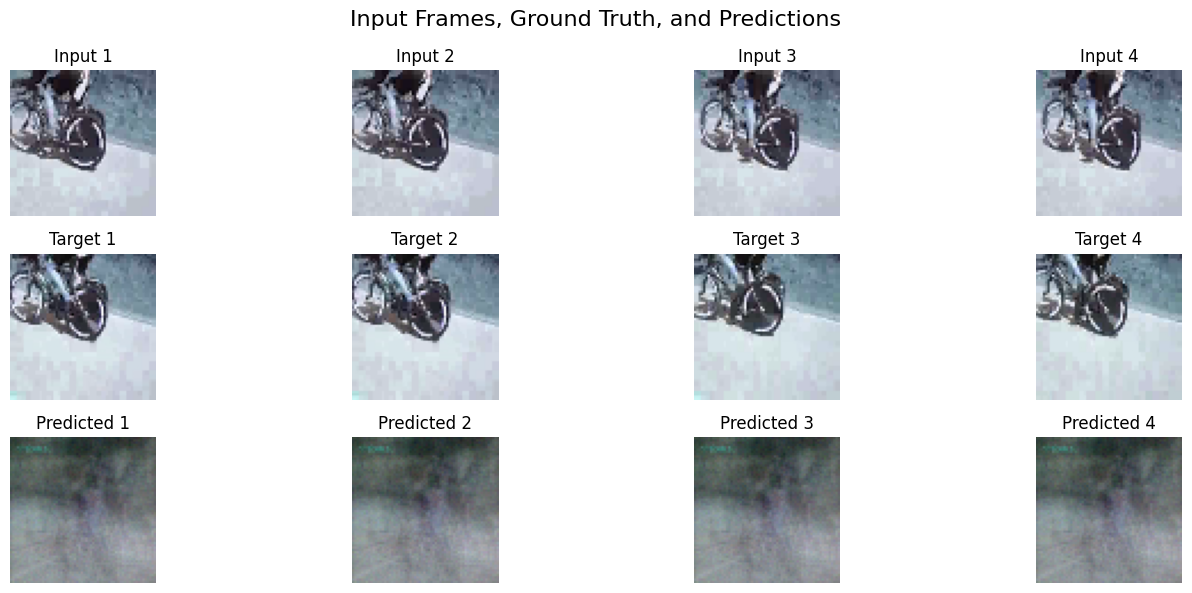

In [15]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Path to the test video
test_video_path = '/kaggle/input/ucf101-action-recognition/test/Biking/v_Biking_g02_c01.avi'

# Function to preprocess a single video
def preprocess_video(video_path, frame_size, sequence_length, prediction_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)  # Resize frame
        frame = frame / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()

    frames = np.array(frames, dtype=np.float32)  # Convert list of frames to numpy array
    
    # Ensure the video has enough frames
    if len(frames) >= sequence_length + prediction_length:
        input_frames = frames[:sequence_length]
        target_frames = frames[sequence_length:sequence_length + prediction_length]
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)
    else:
        raise ValueError("Not enough frames in the video for testing.")

# Preprocess the test video
test_inputs, test_targets = preprocess_video(test_video_path, frame_size, sequence_length, prediction_length)
test_inputs, test_targets = test_inputs.unsqueeze(0).to(device), test_targets.unsqueeze(0).to(device)  # Add batch dimension

# Generate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(test_inputs, test_targets[:, :-1])  # Predict frames

# Convert tensors to numpy for visualization
test_inputs = test_inputs.cpu().numpy()[0]
test_targets = test_targets.cpu().numpy()[0]
test_predictions = test_predictions.cpu().numpy()[0]

# Visualization function
def visualize_test_results(inputs, targets, predictions):
    num_frames = min(len(inputs), len(targets), len(predictions))  # Adjust frame count dynamically
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# Visualize test video results
visualize_test_results(test_inputs, test_targets, test_predictions)

In [16]:
# Save the model
model_path = '/kaggle/working/transformer_video_predictor_biking.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# # Load the model
# model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)
# model.load_state_dict(torch.load(model_path))
# model.eval()  # Set the model to evaluation mode
# print(f'Model loaded from {model_path}')

Model saved to /kaggle/working/transformer_video_predictor_biking.pth


## Wall Push Ups

In [17]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Paths and parameters
train_path = '/kaggle/input/ucf101-action-recognition/train/WallPushups'
frame_size = (64, 64)
sequence_length = 10
prediction_length = 5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Preprocess video frames
def preprocess_videos(video_path, frame_size):
    data = []
    for video_file in os.listdir(video_path):
        if video_file.endswith('.avi'):  # Adjust the extension if necessary
            cap = cv2.VideoCapture(os.path.join(video_path, video_file))
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, frame_size)
                frame = frame / 255.0  # Normalize to [0, 1]
                frames.append(frame)
            cap.release()
            if len(frames) >= sequence_length + prediction_length:
                data.append(np.array(frames, dtype=np.float32))  # Ensure numeric type
    return data

video_data = preprocess_videos(train_path, frame_size)

# 2. Dataset Class
class VideoDataset(Dataset):
    def __init__(self, videos, sequence_length, prediction_length):
        self.videos = videos
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        input_frames = np.array(video[:self.sequence_length], dtype=np.float32)
        target_frames = np.array(video[self.sequence_length:self.sequence_length + self.prediction_length], dtype=np.float32)
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)

# Create dataset and dataloader
dataset = VideoDataset(video_data, sequence_length, prediction_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3. Transformer Video Predictor Model
class TransformerVideoPredictor(nn.Module):
    def __init__(self, input_dim, seq_length, embed_dim, num_heads, num_layers):
        super(TransformerVideoPredictor, self).__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(seq_length, embed_dim))
        self.transformer = nn.Transformer(
            d_model=embed_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            batch_first=True  # Fix for batch-first input
        )
        self.fc = nn.Linear(embed_dim, input_dim)

    def forward(self, x, target):
        b, t, h, w, c = x.size()
        x = x.view(b, t, -1)  # Flatten spatial dimensions
        target = target.view(b, target.size(1), -1)

        # Add positional encoding
        x_embed = self.embed(x) + self.positional_encoding
        target_embed = self.embed(target) + self.positional_encoding[:target.size(1)]

        # Transformer forward pass
        output = self.transformer(x_embed, target_embed)
        output = self.fc(output)
        return output.view(b, target.size(1), h, w, c)

# Instantiate model
input_dim = frame_size[0] * frame_size[1] * 3  # Assuming RGB frames
embed_dim = 128
num_heads = 4
num_layers = 2
model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)

# 4. Training Setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# Training loop
epochs = 60
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # Model prediction
        predictions = model(inputs, targets[:, :-1])  # Use inputs and part of targets for prediction
        
        # Align target shape with predictions
        aligned_targets = targets[:, 1:]  # Shifted by one step to match prediction sequence
        
        # Calculate loss
        loss = criterion(predictions, aligned_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1/60, Loss: 0.1827
Epoch 2/60, Loss: 0.0893
Epoch 3/60, Loss: 0.0837
Epoch 4/60, Loss: 0.0814
Epoch 5/60, Loss: 0.0722
Epoch 6/60, Loss: 0.0653
Epoch 7/60, Loss: 0.0592
Epoch 8/60, Loss: 0.0553
Epoch 9/60, Loss: 0.0507
Epoch 10/60, Loss: 0.0509
Epoch 11/60, Loss: 0.0479
Epoch 12/60, Loss: 0.0463
Epoch 13/60, Loss: 0.0450
Epoch 14/60, Loss: 0.0445
Epoch 15/60, Loss: 0.0442
Epoch 16/60, Loss: 0.0446
Epoch 17/60, Loss: 0.0406
Epoch 18/60, Loss: 0.0364
Epoch 19/60, Loss: 0.0333
Epoch 20/60, Loss: 0.0311
Epoch 21/60, Loss: 0.0297
Epoch 22/60, Loss: 0.0275
Epoch 23/60, Loss: 0.0255
Epoch 24/60, Loss: 0.0248
Epoch 25/60, Loss: 0.0233
Epoch 26/60, Loss: 0.0234
Epoch 27/60, Loss: 0.0215
Epoch 28/60, Loss: 0.0203
Epoch 29/60, Loss: 0.0194
Epoch 30/60, Loss: 0.0179
Epoch 31/60, Loss: 0.0174
Epoch 32/60, Loss: 0.0179
Epoch 33/60, Loss: 0.0182
Epoch 34/60, Loss: 0.0174
Epoch 35/60, Loss: 0.0161
Epoch 36/60, Loss: 0.0142
Epoch 37/60, Loss: 0.0139
Epoch 38/60, Loss: 0.0134
Epoch 39/60, Loss: 0.

In [18]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, test_dataset, num_frames=5):
    model.eval()
    # Select a sample from the test dataset
    inputs, targets = test_dataset[0]  # Replace with any index as needed
    inputs, targets = inputs.unsqueeze(0).to(device), targets.unsqueeze(0).to(device)  # Add batch dimension
    
    # Get predictions
    with torch.no_grad():
        predictions = model(inputs, targets[:, :-1])
    
    # Move tensors to CPU for visualization
    inputs = inputs.cpu().numpy()[0]  # Remove batch dimension
    targets = targets.cpu().numpy()[0]
    predictions = predictions.cpu().numpy()[0]

    # Plot input, ground truth, and predicted frames
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# # Visualize predictions
# visualize_predictions(model, test_dataset)

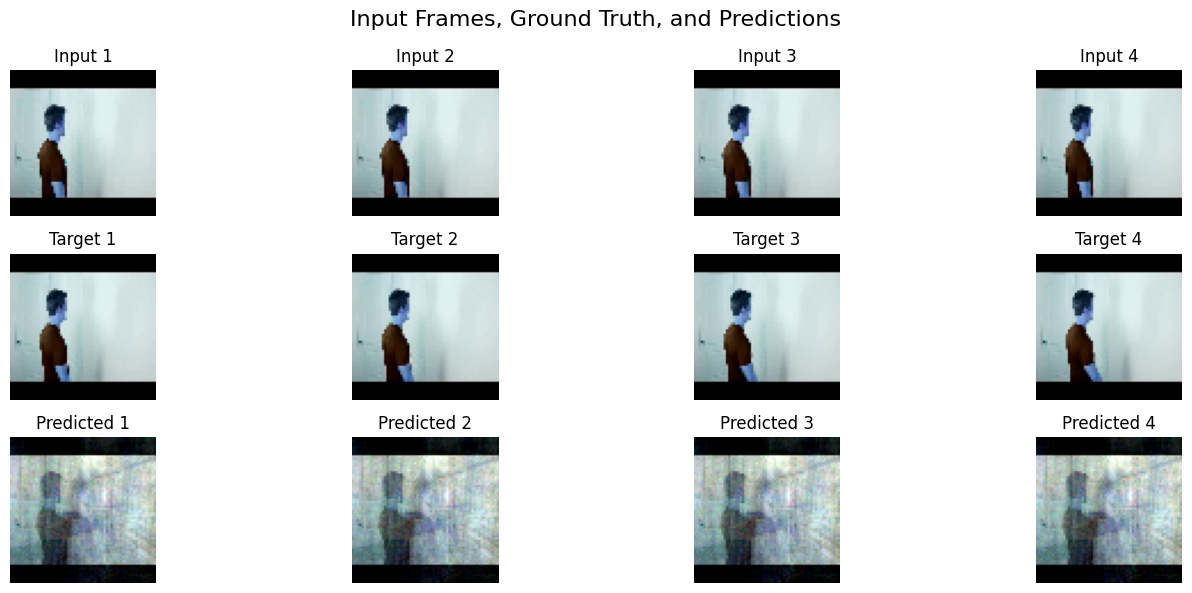

In [19]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Path to the test video
test_video_path = '/kaggle/input/ucf101-action-recognition/test/WallPushups/v_WallPushups_g01_c01.avi'

# Function to preprocess a single video
def preprocess_video(video_path, frame_size, sequence_length, prediction_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)  # Resize frame
        frame = frame / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()

    frames = np.array(frames, dtype=np.float32)  # Convert list of frames to numpy array
    
    # Ensure the video has enough frames
    if len(frames) >= sequence_length + prediction_length:
        input_frames = frames[:sequence_length]
        target_frames = frames[sequence_length:sequence_length + prediction_length]
        return torch.tensor(input_frames, dtype=torch.float32), torch.tensor(target_frames, dtype=torch.float32)
    else:
        raise ValueError("Not enough frames in the video for testing.")

# Preprocess the test video
test_inputs, test_targets = preprocess_video(test_video_path, frame_size, sequence_length, prediction_length)
test_inputs, test_targets = test_inputs.unsqueeze(0).to(device), test_targets.unsqueeze(0).to(device)  # Add batch dimension

# Generate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(test_inputs, test_targets[:, :-1])  # Predict frames

# Convert tensors to numpy for visualization
test_inputs = test_inputs.cpu().numpy()[0]
test_targets = test_targets.cpu().numpy()[0]
test_predictions = test_predictions.cpu().numpy()[0]

# Visualization function
def visualize_test_results(inputs, targets, predictions):
    num_frames = min(len(inputs), len(targets), len(predictions))  # Adjust frame count dynamically
    fig, axes = plt.subplots(3, num_frames, figsize=(15, 6))
    fig.suptitle("Input Frames, Ground Truth, and Predictions", fontsize=16)

    # Input frames
    for i in range(num_frames):
        axes[0, i].imshow(inputs[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")

    # Ground truth frames
    for i in range(num_frames):
        axes[1, i].imshow(targets[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")

    # Predicted frames
    for i in range(num_frames):
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# Visualize test video results
visualize_test_results(test_inputs, test_targets, test_predictions)

In [20]:
# Save the model
model_path = '/kaggle/working/transformer_video_predictor_wall_push_ups.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# # Load the model
# model = TransformerVideoPredictor(input_dim, sequence_length, embed_dim, num_heads, num_layers).to(device)
# model.load_state_dict(torch.load(model_path))
# model.eval()  # Set the model to evaluation mode
# print(f'Model loaded from {model_path}')

Model saved to /kaggle/working/transformer_video_predictor_wall_push_ups.pth
